In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

In [2]:
import io

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
training_letter = pd.read_csv(F"/content/gdrive/My Drive/MNIST_Datasets/emnist-letters-train.csv" )
testing_letter = pd.read_csv(F"/content/gdrive/My Drive/MNIST_Datasets/emnist-letters-test.csv" )

In [4]:
print(f"Training data size is {training_letter.shape}\nTesting data size is {testing_letter.shape}")

Training data size is (88799, 785)
Testing data size is (14799, 785)


In [5]:
#training_letters
y1 = np.array(training_letter.iloc[:,0].values)
x1 = np.array(training_letter.iloc[:,1:].values)
#testing_labels
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(88799,)
(88799, 784)


Visualizing Letter Data - Checking 25 samples

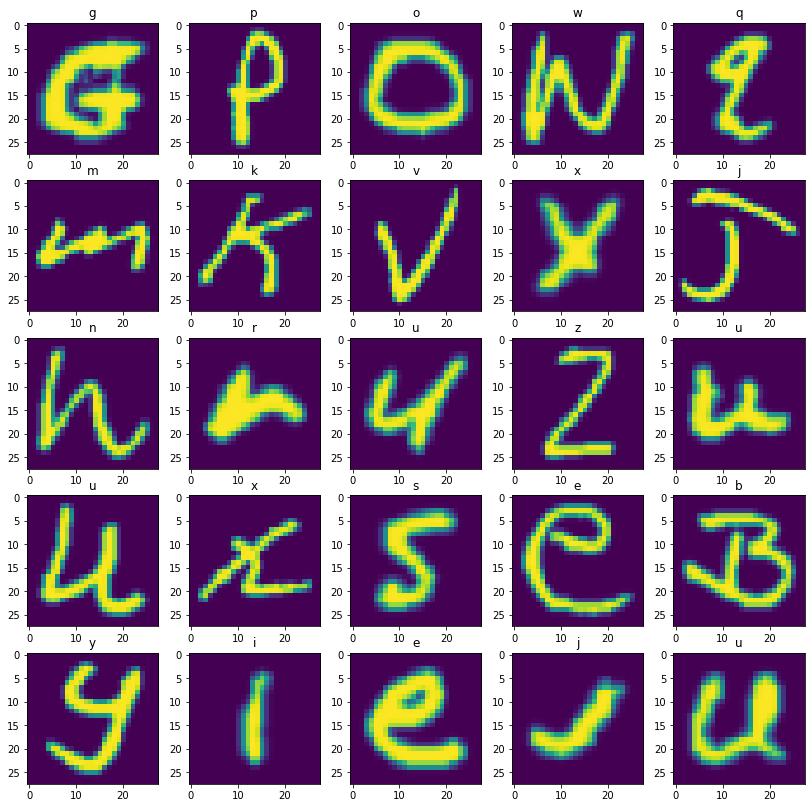

In [6]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

fig, axis = plt.subplots(5,5,figsize=(14,14))

for i,ax in enumerate(axis.flat):
    ax.title.set_text(letters[y1[i] - 1])
    ax.imshow(rotate(x1[i]).reshape(28,28))

Data Pre-Processing

In [7]:
# Normalise and reshape data
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

Checking Number of Classes

In [8]:
np.unique(y1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

Transforming Labels

In [9]:
number_of_classes = 27

y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

Callback API to save best weights and change learning rate
W/ early stopping & LR reduction

In [10]:
#--- Model Checkpoint
MCP = ModelCheckpoint('top_scores_letterNet.h5', verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')

#--- Early Stopping
ES = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')

#--- Learning rate reduction upon plateau
RLP = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [11]:
train_x, test_x, train_y, test_y, = train_test_split(train_images, y1, test_size=0.2, random_state = 42)

# LetterNet
Convolutional Neural Network Model

In [12]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(input_shape=(28,28,1)),

    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

Compile Model

In [13]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Summary to View Model Parameters & Output Shape

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         1

## Train Model
Without data augmentation

In [ ]:
#--- With earlystopping Callbacks
history = model.fit(train_x, train_y, epochs = 3, batch_size = 64, 
                    validation_data = (test_x, test_y),
                    callbacks=[MCP, ES, RLP])

#--- Without Earlystopping Callbacks
#history = model.fit(train_x, train_y, epochs = 30,
#                    validation_data = (test_x, test_y))

# loss_accuracy
loss, accuracy = model.evaluate(test_x, test_y, verbose = False)

### Plot Training Loss & Accuracy Curves
Training and validation 

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Test Loss & Accuracy

In [21]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))
  

In [ ]:
print(f'Test loss: {loss:.5}')
print(f'Test accuracy: {accuracy:.5}')

Plotting Test Performance

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

## With Data Augmentation

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=5,  
        zoom_range = 0.05,  
        width_shift_range=0.05,  
        height_shift_range=0.05,  
        horizontal_flip=False,  
        vertical_flip=False)  

batch_size = 32
epochs = 50

train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)
test_gen = datagen.flow(test_x, test_y, batch_size=batch_size)

Train LetterNet

In [ ]:
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_x.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = test_x.shape[0] // batch_size,
                              callbacks=[MCP])

# loss_accuracy
loss, accuracy = model.evaluate(test_x, test_y, verbose = False)

Plotting Training Curves

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Test Loss and Accuracy

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [ ]:
print(f'Test loss: {loss:.5}')
print(f'Test accuracy: {accuracy:.5}')

Plot Test Curves

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

# Saving Models
Bypass ModelCheckPoint

In [ ]:
!mkdir -p saved_model
model.save('saved_model/letter_model.h5') 

In [ ]:
!ls saved_model/

!ls saved_model/letter_model.h5